In [50]:
import gspread
import pandas as pd
import json
import os
from gspread_dataframe import get_as_dataframe, set_with_dataframe


def get_gspread_client():
    """Get gspread client using either file or environment variable"""
    gdrive_creds_json = os.getenv("GDRIVE_CREDS_JSON")
    
    if gdrive_creds_json:
        print("Using environment variable for credentials")
        try:
            creds_dict = json.loads(gdrive_creds_json)
            return gspread.service_account_from_dict(creds_dict)
        except json.JSONDecodeError as e:
            print(f"Error parsing GDRIVE_CREDS_JSON: {e}")
            raise
    else:
        print("Using file for credentials")
        return gspread.service_account(filename='gdrive-creds.json')


def get_or_create_worksheet(sh, title, rows=1000, cols=26):
    """Get worksheet by name, or create if it does not exist."""
    try:
        return sh.worksheet(title)
    except gspread.exceptions.WorksheetNotFound:
        print(f"Creating new worksheet: {title}")
        return sh.add_worksheet(title=title, rows=rows, cols=cols)

In [51]:
from gspread_dataframe import get_as_dataframe

# Connect
gc = get_gspread_client()
sh = gc.open("myportfolio")

# Get trades and positions
ws_trades = sh.worksheet("flex-trades")
ws_positions = sh.worksheet("flex-positions")

trades = get_as_dataframe(ws_trades, evaluate_formulas=True, na_filter=False)
positions = get_as_dataframe(ws_positions, evaluate_formulas=True, na_filter=False)

# Clean empty rows
trades = trades.dropna(how='all')
positions = positions.dropna(how='all')

positions_summary = positions[positions['levelOfDetail'] == 'SUMMARY'].copy()
positions_lot = positions[positions['levelOfDetail'] == 'LOT'].copy()




Using file for credentials


In [52]:
import pandas as pd
import numpy as np

# Step 1: Load data
positions = get_as_dataframe(ws_positions, evaluate_formulas=True, na_filter=False)

positions['openDateTime'] = positions['openDateTime'].astype(str).replace('nan', '')

# Step 2: Parse openDateTime from IBKR format
def parse_ibkr_datetime(val):
    try:
        if pd.isnull(val):
            return pd.NaT
        val = str(val)
        if ';' in val and len(val) >= 15:
            return pd.to_datetime(val, format='%Y%m%d;%H%M%S')
        elif len(val) == 8 and val.isdigit():
            return pd.to_datetime(val, format='%Y%m%d')
        else:
            return pd.NaT
    except Exception:
        return pd.NaT

positions['openDateTime'] = positions['openDateTime'].apply(parse_ibkr_datetime)

# Step 3: Clean up levelOfDetail and ensure LOT rows come before SUMMARY
positions['levelOfDetail'] = positions['levelOfDetail'].str.strip().str.upper()
positions['levelOfDetail_order'] = positions['levelOfDetail'].map({'LOT': 0, 'SUMMARY': 1, '': 2})

# Step 4: Ensure all relevant columns are numeric
num_cols = [
    'positionValue', 'markPrice', 'costBasisPrice', 'position',
    'multiplier', 'fxRateToBase', 'fifoPnlUnrealized'
]
for col in num_cols:
    positions[col] = pd.to_numeric(positions[col], errors='coerce')

# Step 5: Sort so LOTs are before SUMMARY by symbol
positions = positions.sort_values(by=['symbol', 'levelOfDetail_order'])

# Step 6: Backfill openDateTime from LOT to SUMMARY by symbol
positions['openDateTime'] = positions.groupby('symbol')['openDateTime'].ffill()

# Step 7: Filter only SUMMARY rows
positions_summary = positions[positions['levelOfDetail'] == 'SUMMARY'].copy()

# Step 8: Calculate portfolio metrics
positions_summary['WeightInPortfolio'] = (positions_summary['positionValue'] / positions_summary['positionValue'].sum()) * 100
positions_summary['UnrealizedReturnPct'] = ((positions_summary['markPrice'] - positions_summary['costBasisPrice']) / positions_summary['costBasisPrice']) * 100
positions_summary['UnrealizedPnL'] = (positions_summary['markPrice'] - positions_summary['costBasisPrice']) * positions_summary['position'] * positions_summary['multiplier']

positions_summary['days_held'] = (pd.Timestamp.today() - positions_summary['openDateTime']).dt.days

positions_summary['AnnualizedReturn'] = np.where(
    positions_summary['days_held'] > 0,
    ((positions_summary['markPrice'] / positions_summary['costBasisPrice']) ** (365 / positions_summary['days_held']) - 1) * 100,
    np.nan
)
positions_summary['AnnualizedReturn'] = positions_summary['AnnualizedReturn'].replace([np.inf, -np.inf], np.nan)

# Step 9: Ensure metrics are numeric and rounded
calc_cols = ['WeightInPortfolio', 'UnrealizedReturnPct', 'AnnualizedReturn', 'UnrealizedPnL']
for col in calc_cols:
    positions_summary[col] = pd.to_numeric(positions_summary[col], errors='coerce').round(0)

# Optional: Clean up temp column
positions_summary = positions_summary.drop(columns=['levelOfDetail_order'], errors='ignore')

# Step 10: Display result
positions_summary


,accountId,acctAlias,model,currency,fxRateToBase,assetCategory,subCategory,symbol,description,conid,...,deliveryType,commodityType,fineness,weight,position_key,WeightInPortfolio,UnrealizedReturnPct,UnrealizedPnL,days_held,AnnualizedReturn
0,U19575352,,,USD,1.0,STK,COMMON,ACHR,ARCHER AVIATION INC-A,514640214,...,,,0,0,U19575352_514640214_20250626,4.0,5.0,23.0,2,359214.0
24,U19575352,,,USD,1.0,STK,COMMON,ACHR,ARCHER AVIATION INC-A,514640214,...,,,0,0,U19575352_514640214_20250627,4.0,3.0,17.0,2,44798.0
2,U19575352,,,USD,1.0,STK,COMMON,AMZN,AMAZON.COM INC,3691937,...,,,0,0,U19575352_3691937_20250626,8.0,4.0,43.0,5,1778.0
26,U19575352,,,USD,1.0,STK,COMMON,AMZN,AMAZON.COM INC,3691937,...,,,0,0,U19575352_3691937_20250627,8.0,7.0,74.0,5,14473.0
4,U19575352,,,USD,1.0,STK,COMMON,GOOG,ALPHABET INC-CL C,208813720,...,,,0,0,U19575352_208813720_20250626,13.0,5.0,85.0,5,3817.0
28,U19575352,,,USD,1.0,STK,COMMON,GOOG,ALPHABET INC-CL C,208813720,...,,,0,0,U19575352_208813720_20250627,13.0,7.0,124.0,5,19099.0
7,U19575352,,,USD,1.0,STK,ETF,IB01,ISHARES US TREAS 0-1YR USD A,354802220,...,,,0,0,U19575352_354802220_20250626,9.0,-0.0,-1.0,5,-6.0
31,U19575352,,,USD,1.0,STK,ETF,IB01,ISHARES US TREAS 0-1YR USD A,354802220,...,,,0,0,U19575352_354802220_20250627,9.0,-0.0,-1.0,5,-5.0
10,U19575352,,,USD,1.0,STK,COMMON,IBKR,INTERACTIVE BROKERS GRO-CL A,43645865,...,,,0,0,U19575352_43645865_20250626,1.0,3.0,3.0,22,71.0
34,U19575352,,,USD,1.0,STK,COMMON,IBKR,INTERACTIVE BROKERS GRO-CL A,43645865,...,,,0,0,U19575352_43645865_20250627,1.0,4.0,4.0,22,103.0


In [53]:
positions_summary.columns

Index(['accountId', 'acctAlias', 'model', 'currency', 'fxRateToBase',
       'assetCategory', 'subCategory', 'symbol', 'description', 'conid',
       'securityID', 'securityIDType', 'cusip', 'isin', 'figi',
       'listingExchange', 'underlyingConid', 'underlyingSymbol',
       'underlyingSecurityID', 'underlyingListingExchange', 'issuer',
       'issuerCountryCode', 'multiplier', 'strike', 'expiry', 'putCall',
       'principalAdjustFactor', 'reportDate', 'position', 'markPrice',
       'positionValue', 'openPrice', 'costBasisPrice', 'costBasisMoney',
       'percentOfNAV', 'fifoPnlUnrealized', 'side', 'levelOfDetail',
       'openDateTime', 'holdingPeriodDateTime', 'vestingDate', 'code',
       'originatingOrderID', 'originatingTransactionID', 'accruedInt',
       'serialNumber', 'deliveryType', 'commodityType', 'fineness', 'weight',
       'position_key', 'WeightInPortfolio', 'UnrealizedReturnPct',
       'UnrealizedPnL', 'days_held', 'AnnualizedReturn'],
      dtype='object')

In [57]:
# Get latest report date if you want to use the same as the rest
latest_report_date = positions_summary['reportDate'].max() if 'reportDate' in positions_summary.columns else pd.NaT

cash_row = {
    'symbol': 'CASH',
    'positionValue': cash_value,
    'listingExchange': None,
    'reportDate': latest_report_date
}

positions_with_cash = pd.concat([
    positions_summary,
    pd.DataFrame([cash_row])
], ignore_index=True)

positions_with_cash['WeightInPortfolio'] = (
    positions_with_cash['positionValue'] / positions_with_cash['positionValue'].sum()
) * 100

print(positions_with_cash[['symbol', 'positionValue', 'WeightInPortfolio', 'listingExchange', 'reportDate']])


   symbol  positionValue  WeightInPortfolio listingExchange reportDate
0    ACHR         529.50           2.276009            NYSE   20250626
1    ACHR         523.50           2.250218            NYSE   20250627
2    AMZN        1085.60           4.666355          NASDAQ   20250626
3    AMZN        1116.50           4.799176          NASDAQ   20250627
4    GOOG        1744.30           7.497719          NASDAQ   20250626
5    GOOG        1782.70           7.662778          NASDAQ   20250627
6    IB01        1250.75           5.376238          LSEETF   20250626
7    IB01        1250.96           5.377140          LSEETF   20250627
8    IBKR         102.95           0.442521          NASDAQ   20250626
9    IBKR         104.01           0.447078          NASDAQ   20250627
10   IBTA         501.43           2.155352          LSEETF   20250626
11   IBTA         501.65           2.156298          LSEETF   20250627
12   IGLN         491.06           2.110778          LSEETF   20250626
13   I

In [58]:
# Make sure reportDate is a string or datetime
positions_with_cash['reportDate'] = pd.to_datetime(positions_with_cash['reportDate'], format='%Y%m%d')

# Group by date and sum the positions for each date
portfolio_history = positions_with_cash.groupby('reportDate', as_index=False)['positionValue'].sum()
portfolio_history.rename(columns={'reportDate': 'Date', 'positionValue': 'PortfolioValue'}, inplace=True)

print(portfolio_history)


        Date  PortfolioValue
0 2025-06-26         6599.69
1 2025-06-27        16664.72


In [60]:
N = 5
latest_date = positions_with_cash['reportDate'].max()
latest_positions = positions_with_cash[positions_with_cash['reportDate'] == latest_date]

top_n = latest_positions[latest_positions['UnrealizedPnL'] > 0].nlargest(N, 'UnrealizedPnL')[['symbol', 'UnrealizedPnL']]
bottom_n = latest_positions[latest_positions['UnrealizedPnL'] < 0].nsmallest(N, 'UnrealizedPnL')[['symbol', 'UnrealizedPnL']]

print(f"Top contributors for {latest_date.date()}:\n", top_n)
print(f"Top detractors for {latest_date.date()}:\n", bottom_n)


Top contributors for 2025-06-27:
    symbol  UnrealizedPnL
5    GOOG          124.0
3    AMZN           74.0
1    ACHR           17.0
17   VUSD           13.0
15   IWDA           10.0
Top detractors for 2025-06-27:
    symbol  UnrealizedPnL
13   IGLN          -19.0
7    IB01           -1.0
11   IBTA           -1.0


In [64]:
# First run with 10%/1% thresholds
# positions_with_cash['ConcentrationFlag'] = positions_with_cash['WeightInPortfolio'] > 10
# positions_with_cash['UnderDiversifiedFlag'] = positions_with_cash['WeightInPortfolio'] < 1

# Later, change the thresholds:
positions_with_cash['ConcentrationFlag'] = positions_with_cash['WeightInPortfolio'] > 15
positions_with_cash['UnderDiversifiedFlag'] = positions_with_cash['WeightInPortfolio'] < 0.5


print(positions_with_cash[['symbol', 'WeightInPortfolio', 'ConcentrationFlag', 'UnderDiversifiedFlag']])


   symbol  WeightInPortfolio  ConcentrationFlag  UnderDiversifiedFlag
0    ACHR           2.276009              False                 False
1    ACHR           2.250218              False                 False
2    AMZN           4.666355              False                 False
3    AMZN           4.799176              False                 False
4    GOOG           7.497719              False                 False
5    GOOG           7.662778              False                 False
6    IB01           5.376238              False                 False
7    IB01           5.377140              False                 False
8    IBKR           0.442521              False                  True
9    IBKR           0.447078              False                  True
10   IBTA           2.155352              False                 False
11   IBTA           2.156298              False                 False
12   IGLN           2.110778              False                 False
13   IGLN           

In [66]:
import yfinance as yf
import numpy as np
import pandas as pd  # Needed for MultiIndex handling

EXCHANGE_SUFFIX = {
    "NASDAQ": "",
    "NYSE": "",
    "AMEX": "",
    "LSE": ".L",
    "LSEETF": ".L",
    # ... add more as needed
}

def format_yahoo_symbol(symbol, exchange):
    suffix = EXCHANGE_SUFFIX.get(str(exchange).upper(), "")
    return f"{symbol}{suffix}"

# def compute_var(symbol, position_value, days=1, confidence=0.95):
#     try:
#         data = yf.download(symbol, period='1y')
#         # Check if MultiIndex columns (occurs for some exchanges)
#         if isinstance(data.columns, pd.MultiIndex):
#             # Try to get ('Adj Close', symbol) or ('Close', symbol)
#             if ('Adj Close', symbol) in data:
#                 prices = data[('Adj Close', symbol)]
#             elif ('Close', symbol) in data:
#                 prices = data[('Close', symbol)]
#             else:
#                 print(f"No valid price data (MultiIndex) for {symbol}")
#                 return np.nan
#         else:
#             # Single symbol, regular columns
#             if 'Adj Close' in data:
#                 prices = data['Adj Close']
#             elif 'Close' in data:
#                 prices = data['Close']
#             else:
#                 print(f"No valid price data for {symbol}")
#                 return np.nan
#         returns = prices.pct_change().dropna()
#         if returns.empty:
#             print(f"No returns data for {symbol}")
#             return np.nan
#         var = np.percentile(returns, (1 - confidence) * 100)
#         return round(var * position_value, 2)
#     except Exception as e:
#         print(f"Error for {symbol}: {e}")
#         return np.nan
    
def compute_var_es(symbol, position_value, days=1, confidence=0.95):
    try:
        data = yf.download(symbol, period='1y', auto_adjust=True)
        # MultiIndex handling (same as before)
        if isinstance(data.columns, pd.MultiIndex):
            if ('Adj Close', symbol) in data:
                prices = data[('Adj Close', symbol)]
            elif ('Close', symbol) in data:
                prices = data[('Close', symbol)]
            else:
                print(f"No valid price data (MultiIndex) for {symbol}")
                return np.nan, np.nan
        else:
            if 'Adj Close' in data:
                prices = data['Adj Close']
            elif 'Close' in data:
                prices = data['Close']
            else:
                print(f"No valid price data for {symbol}")
                return np.nan, np.nan
        returns = prices.pct_change().dropna()
        if returns.empty:
            print(f"No returns data for {symbol}")
            return np.nan, np.nan
        var = np.percentile(returns, (1 - confidence) * 100)
        # ES/CVaR is the mean of losses worse than VaR
        es = returns[returns <= var].mean()
        var_value = round(var * position_value, 2)
        es_value = round(es * position_value, 2)
        return var_value, es_value
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        return np.nan, np.nan



# Create Yahoo-compatible symbol column
positions_with_cash['YahooSymbol'] = positions_with_cash.apply(
    lambda row: format_yahoo_symbol(row['symbol'], row['listingExchange']), axis=1
)





# # Compute VaR using the Yahoo symbol
# positions_with_cash['VaR_1d'] = positions_with_cash.apply(
#     lambda row: compute_var(row['YahooSymbol'], row['positionValue']), axis=1
# )

# Compute VaR and ES for each row
positions_with_cash[['VaR_1d', 'CVaR_1d']] = positions_with_cash.apply(
    lambda row: pd.Series(compute_var_es(row['YahooSymbol'], row['positionValue'])),
    axis=1
)

positions_with_cash.loc[positions_with_cash['symbol'] == 'CASH', ['VaR_1d', 'CVaR_1d']] = 0


print(positions_with_cash[['symbol', 'listingExchange', 'YahooSymbol', 'positionValue', 'VaR_1d','CVaR_1d']])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

   symbol listingExchange YahooSymbol  positionValue  VaR_1d  CVaR_1d
0    ACHR            NYSE        ACHR         529.50  -43.48   -62.40
1    ACHR            NYSE        ACHR         523.50  -42.99   -61.69
2    AMZN          NASDAQ        AMZN        1085.60  -34.70   -52.07
3    AMZN          NASDAQ        AMZN        1116.50  -35.69   -53.55
4    GOOG          NASDAQ        GOOG        1744.30  -61.66   -81.89
5    GOOG          NASDAQ        GOOG        1782.70  -63.01   -83.69
6    IB01          LSEETF      IB01.L        1250.75   -0.22    -0.29
7    IB01          LSEETF      IB01.L        1250.96   -0.22    -0.29
8    IBKR          NASDAQ        IBKR         102.95   -3.62    -6.51
9    IBKR          NASDAQ        IBKR         104.01   -3.65    -6.58
10   IBTA          LSEETF      IBTA.L         501.43   -0.74    -1.19
11   IBTA          LSEETF      IBTA.L         501.65   -0.74    -1.19
12   IGLN          LSEETF      IGLN.L         491.06   -8.22   -12.62
13   IGLN          L

In [67]:
print(positions_with_cash[['symbol', 'listingExchange', 'YahooSymbol', 'positionValue', 'VaR_1d','CVaR_1d']])
positions_with_cash

   symbol listingExchange YahooSymbol  positionValue  VaR_1d  CVaR_1d
0    ACHR            NYSE        ACHR         529.50  -43.48   -62.40
1    ACHR            NYSE        ACHR         523.50  -42.99   -61.69
2    AMZN          NASDAQ        AMZN        1085.60  -34.70   -52.07
3    AMZN          NASDAQ        AMZN        1116.50  -35.69   -53.55
4    GOOG          NASDAQ        GOOG        1744.30  -61.66   -81.89
5    GOOG          NASDAQ        GOOG        1782.70  -63.01   -83.69
6    IB01          LSEETF      IB01.L        1250.75   -0.22    -0.29
7    IB01          LSEETF      IB01.L        1250.96   -0.22    -0.29
8    IBKR          NASDAQ        IBKR         102.95   -3.62    -6.51
9    IBKR          NASDAQ        IBKR         104.01   -3.65    -6.58
10   IBTA          LSEETF      IBTA.L         501.43   -0.74    -1.19
11   IBTA          LSEETF      IBTA.L         501.65   -0.74    -1.19
12   IGLN          LSEETF      IGLN.L         491.06   -8.22   -12.62
13   IGLN          L

,accountId,acctAlias,model,currency,fxRateToBase,assetCategory,subCategory,symbol,description,conid,...,WeightInPortfolio,UnrealizedReturnPct,UnrealizedPnL,days_held,AnnualizedReturn,ConcentrationFlag,UnderDiversifiedFlag,YahooSymbol,VaR_1d,CVaR_1d
0,U19575352,,,USD,1.0,STK,COMMON,ACHR,ARCHER AVIATION INC-A,514640214,...,2.276009,5.0,23.0,2.0,359214.0,False,False,ACHR,-43.48,-62.40
1,U19575352,,,USD,1.0,STK,COMMON,ACHR,ARCHER AVIATION INC-A,514640214,...,2.250218,3.0,17.0,2.0,44798.0,False,False,ACHR,-42.99,-61.69
2,U19575352,,,USD,1.0,STK,COMMON,AMZN,AMAZON.COM INC,3691937,...,4.666355,4.0,43.0,5.0,1778.0,False,False,AMZN,-34.70,-52.07
3,U19575352,,,USD,1.0,STK,COMMON,AMZN,AMAZON.COM INC,3691937,...,4.799176,7.0,74.0,5.0,14473.0,False,False,AMZN,-35.69,-53.55
4,U19575352,,,USD,1.0,STK,COMMON,GOOG,ALPHABET INC-CL C,208813720,...,7.497719,5.0,85.0,5.0,3817.0,False,False,GOOG,-61.66,-81.89
5,U19575352,,,USD,1.0,STK,COMMON,GOOG,ALPHABET INC-CL C,208813720,...,7.662778,7.0,124.0,5.0,19099.0,False,False,GOOG,-63.01,-83.69
6,U19575352,,,USD,1.0,STK,ETF,IB01,ISHARES US TREAS 0-1YR USD A,354802220,...,5.376238,-0.0,-1.0,5.0,-6.0,False,False,IB01.L,-0.22,-0.29
7,U19575352,,,USD,1.0,STK,ETF,IB01,ISHARES US TREAS 0-1YR USD A,354802220,...,5.377140,-0.0,-1.0,5.0,-5.0,False,False,IB01.L,-0.22,-0.29
8,U19575352,,,USD,1.0,STK,COMMON,IBKR,INTERACTIVE BROKERS GRO-CL A,43645865,...,0.442521,3.0,3.0,22.0,71.0,False,True,IBKR,-3.62,-6.51
9,U19575352,,,USD,1.0,STK,COMMON,IBKR,INTERACTIVE BROKERS GRO-CL A,43645865,...,0.447078,4.0,4.0,22.0,103.0,False,True,IBKR,-3.65,-6.58


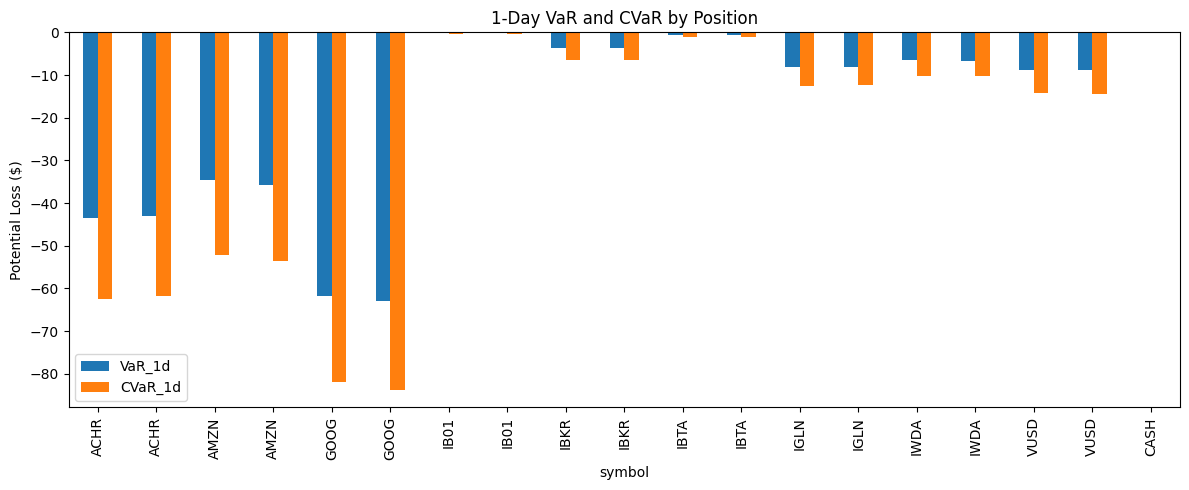

In [68]:
import matplotlib.pyplot as plt

positions_with_cash.set_index('symbol')[['VaR_1d', 'CVaR_1d']].plot(kind='bar', figsize=(12,5))
plt.title('1-Day VaR and CVaR by Position')
plt.ylabel('Potential Loss ($)')
plt.tight_layout()
plt.show()


In [72]:
import pandas as pd
import numpy as np

# Make sure reportDate is datetime (in case it's a string)
positions_with_cash['reportDate'] = pd.to_datetime(positions_with_cash['reportDate'], format='%Y%m%d')

# Sum portfolio value by date
portfolio_history = (
    positions_with_cash.groupby('reportDate', as_index=False)['positionValue'].sum()
    .rename(columns={'reportDate': 'Date', 'positionValue': 'PortfolioValue'})
    .sort_values('Date')
    .reset_index(drop=True)
)

portfolio_history

,Date,PortfolioValue
0,2025-06-26,6599.69
1,2025-06-27,16664.72


In [73]:
portfolio_history['DailyReturn'] = portfolio_history['PortfolioValue'].pct_change()
portfolio_history['CumulativeReturn'] = (1 + portfolio_history['DailyReturn']).cumprod() - 1

# Rolling 21-day (about a trading month) annualized volatility
portfolio_history['RollingVol_21d'] = portfolio_history['DailyReturn'].rolling(21).std() * np.sqrt(252)

# Rolling max and drawdown
portfolio_history['RollingMax'] = portfolio_history['PortfolioValue'].cummax()
portfolio_history['Drawdown'] = portfolio_history['PortfolioValue'] / portfolio_history['RollingMax'] - 1
portfolio_history

,Date,PortfolioValue,DailyReturn,CumulativeReturn,RollingVol_21d,RollingMax,Drawdown
0,2025-06-26,6599.69,NaN,NaN,NaN,6599.69,0.0
1,2025-06-27,16664.72,1.525076,1.525076,NaN,16664.72,0.0


In [74]:
risk_free_rate = 0.05  # annual
mean_return = portfolio_history['DailyReturn'].mean()
std_return = portfolio_history['DailyReturn'].std()
sharpe_ratio = (mean_return * 252 - risk_free_rate) / (std_return * np.sqrt(252))

downside_std = portfolio_history['DailyReturn'][portfolio_history['DailyReturn'] < 0].std()
sortino_ratio = (mean_return * 252 - risk_free_rate) / (downside_std * np.sqrt(252))

print(f"Sharpe Ratio: {sharpe_ratio:.2f}, Sortino Ratio: {sortino_ratio:.2f}")


Sharpe Ratio: nan, Sortino Ratio: nan


In [75]:
# For UnrealizedPnL by date
pnl_by_date = (
    positions_with_cash.groupby('reportDate')['UnrealizedPnL'].sum().rename('UnrealizedPnL')
)
portfolio_history = portfolio_history.merge(
    pnl_by_date, left_on='Date', right_index=True, how='left'
)

print(portfolio_history[['Date', 'PortfolioValue', 'UnrealizedPnL']].tail())


        Date  PortfolioValue  UnrealizedPnL
0 2025-06-26         6599.69          157.0
1 2025-06-27        16664.72          221.0


In [15]:
# Example: append today's portfolio value to a time series CSV or DataFrame
import datetime

today = datetime.date.today()
current_value = positions_with_cash['positionValue'].sum()
# Append to a CSV or DataFrame
# For first run, initialize the DataFrame:
portfolio_history = pd.DataFrame({'Date': [today], 'PortfolioValue': [current_value]})


# On subsequent runs, load and append
# portfolio_history = pd.read_csv('portfolio_history.csv')
# portfolio_history = pd.concat([portfolio_history, pd.DataFrame({'Date': [today], 'PortfolioValue': [current_value]})], ignore_index=True)

portfolio_history['DailyReturn'] = portfolio_history['PortfolioValue'].pct_change()
portfolio_history['CumulativeReturn'] = (1 + portfolio_history['DailyReturn']).cumprod() - 1

print(portfolio_history.tail())




         Date  PortfolioValue  DailyReturn  CumulativeReturn
0  2025-06-28        23264.41          NaN               NaN


In [16]:
portfolio_history['RollingVol_21d'] = portfolio_history['DailyReturn'].rolling(21).std() * np.sqrt(252)
print(portfolio_history[['Date', 'RollingVol_21d']].tail())


         Date  RollingVol_21d
0  2025-06-28             NaN


In [17]:
risk_free_rate = 0.05  # 5% annual risk-free rate (adjust as needed)
mean_return = portfolio_history['DailyReturn'].mean()
std_return = portfolio_history['DailyReturn'].std()
sharpe_ratio = (mean_return * 252 - risk_free_rate) / (std_return * np.sqrt(252))

downside_std = portfolio_history['DailyReturn'][portfolio_history['DailyReturn'] < 0].std()
sortino_ratio = (mean_return * 252 - risk_free_rate) / (downside_std * np.sqrt(252))

print(f"Sharpe Ratio: {sharpe_ratio:.2f}, Sortino Ratio: {sortino_ratio:.2f}")


Sharpe Ratio: nan, Sortino Ratio: nan


In [18]:
portfolio_history['RollingMax'] = portfolio_history['PortfolioValue'].cummax()
portfolio_history['Drawdown'] = portfolio_history['PortfolioValue'] / portfolio_history['RollingMax'] - 1

print(portfolio_history[['Date', 'Drawdown']].tail())


         Date  Drawdown
0  2025-06-28       0.0


In [20]:
# Each day, sum PnLs from positions:
portfolio_history['UnrealizedPnL'] = positions_summary['UnrealizedPnL'].sum()
#portfolio_history['RealizedPnL'] = positions_summary['RealizedPnL'].sum()

print(portfolio_history[['Date', 'UnrealizedPnL']].tail())


         Date  UnrealizedPnL
0  2025-06-28          378.0
